## Problem Statement 

Build a model that is able to classify customer complaints based on the products/services. By doing so, model can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

Perform topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, Model will be able to map each ticket onto its respective department/category. Then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Table of Contents:


1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
#Mount google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import required libraries
import json 
import numpy as np
import pandas as pd
from collections import defaultdict
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

!pip install swifter
import swifter

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 280 kB 7.4 MB/s 
     |████████████████████████████████| 132 kB 73.7 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


## Loading the data


In [6]:
# Opening JSON file 
f = open("/content/drive/MyDrive/complaints-2021-05-14_08_16.json")# Write the path to your data file and load it 
  
# returns JSON object as a dictionary
data = json.load(f)

#The data is in JSON format and so need to convert it to a dataframe.
data=pd.json_normalize(data)

In [7]:
#Shape of the dataframe
data.shape

(78313, 22)

## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.

data.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [9]:
#Dataframe column names
data.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign new column names

#Remove "_source." from columns name
data = data.rename(columns = lambda x: x.replace("_source.",""))

#Remove starting underscore from columns name (e.g _index to index)
data = data.rename(columns = lambda x: re.sub('^_','',x))

#Column names after cleaning
data.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign nan in place of blanks in the complaints column
data['complaint_what_happened'] = data['complaint_what_happened'].replace("",np.nan)

In [12]:
#Remove all rows where complaints column is nan
data = data[~((data['complaint_what_happened'].isnull()) | (data['complaint_what_happened'].str.len()==0 ))]

#Shape of the dataframe after removing rows
data.shape

(21072, 22)

## Prepare the text for topic modeling

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.

In [13]:
# Function to clean the text and remove all the unnecessary elements.
def cleantext(text):
  #Make the text lowercase
  text = text.lower()

  #Remove text in square brackets
  text = re.sub('\[[\w ]+\]','',text)

  #Remove punctuation
  text = re.sub(r'[^a-zA-Z0-9\s]','', text)

  #Remove words containing numbers
  text = re.sub(r'\w*\d\w*','',text)  #Remove numbers also
  #text = re.sub('[a-z]+\d+\w+|\d+[a-z]{1,}\w{0,}','',text) ->Remove words containing numbers

  #Remove extra spaces
  text = re.sub(' {2,}',' ',text)

  return text

data['complaint_what_happened'] = data['complaint_what_happened'].swifter.apply(cleantext)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [14]:
#After cleaning remove any row having complaint length is 0.
data = data[~(data['complaint_what_happened'].str.len()==0)]
data.shape

(21069, 22)

In [15]:
# Function to Lemmatize the texts

def lemmatizetext(text):
  doc = nlp(text)
  lemtext = [word.lemma_ for word in doc]
  lemstring =" ".join(lemtext)  
  return lemstring

data['lemmatized complaints'] = data['complaint_what_happened'].swifter.apply(lemmatizetext)

Pandas Apply:   0%|          | 0/21069 [00:00<?, ?it/s]

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = data[['complaint_what_happened','lemmatized complaints']]

In [17]:
df_clean

,complaint_what_happened,lemmatized complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade -PRON- xxxx xxxx card in and be tell...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs -PRON- hav...


In [18]:
# Function to extract the POS tags 

def extractpos(text):
  words= []
  for word in nlp(text):
    if (word.pos_ == 'NOUN'):
      words.append(str(word))
  POS_removed_text = " ".join(words)
  return POS_removed_text

df_clean['complaint_POS_removed'] = df_clean['lemmatized complaints'].swifter.apply(extractpos)

Pandas Apply:   0%|          | 0/21069 [00:00<?, ?it/s]

In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade -PRON- xxxx xxxx card in and be tell...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check chase account fund account money say...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs -PRON- hav...,credit chase credit card chase freedom xxxx pr...


## Exploratory data analysis to get familiar with the data.

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

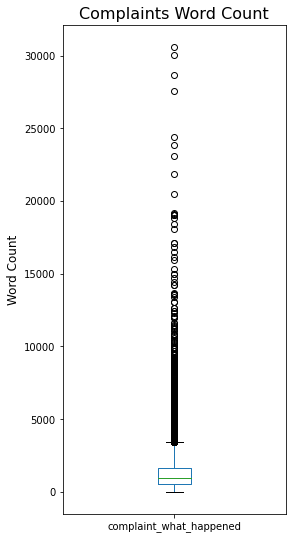

In [20]:
# visualise the data according to the 'Complaint' character length
fig = plt.figure(figsize=(4,9))
complaint_len = df_clean['complaint_what_happened'].str.len()
complaint_len.plot.box()
plt.ylabel("Word Count", fontsize=12)
plt.title('Complaints Word Count', fontsize=16)
plt.show()

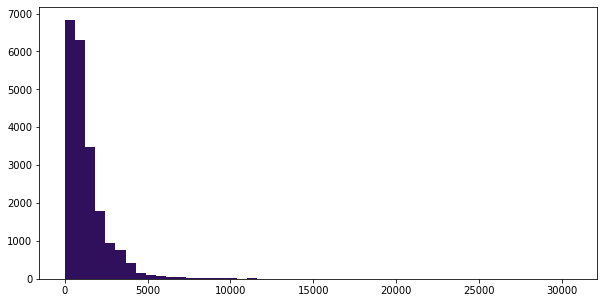

In [21]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(df_clean['complaint_what_happened'].str.len(), bins=50, color='#30105C')
plt.show()

In [22]:
complaint_len.describe()

count    21069.000000
mean      1320.054298
std       1434.959331
min          5.000000
25%        501.000000
50%        938.000000
75%       1659.000000
max      30594.000000
Name: complaint_what_happened, dtype: float64

Observation:
- Most of the complaint having length between

#### Find the top 40 words by frequency among all the articles after processing the text.

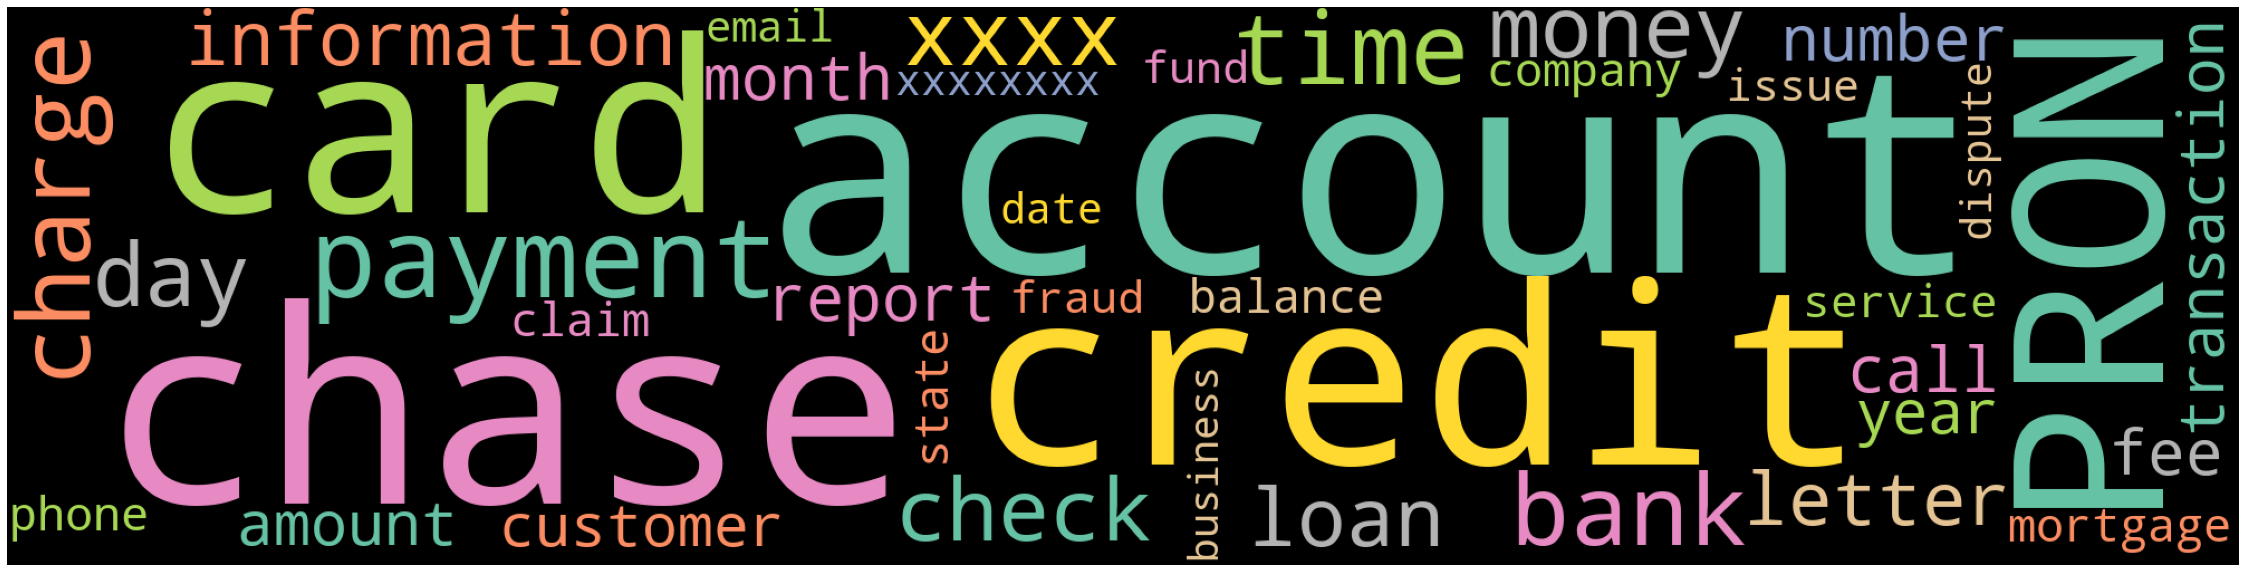

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

freqwords = " ".join(df_clean['complaint_POS_removed'])

# Generate wordcloud
wordcloud = WordCloud(width = 2000, height = 500, random_state=1, background_color='black', colormap='Set2', collocations=False,max_words=40,stopwords = STOPWORDS).generate(freqwords)
# Plot
plot_cloud(wordcloud)

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [25]:
#Remoe extra spaces after lemaatization and POS tag removal.
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].swifter.apply(lambda x: re.sub(' {2,}',' ',x))

Pandas Apply:   0%|          | 0/21069 [00:00<?, ?it/s]

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
#Function to generate n_grams
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[', '.join(ngram) for ngram in temp]
  return ans

In [27]:
# code to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigram=defaultdict(int)
for text in df_clean['Complaint_clean']:
  for word in generate_N_grams(text,1):
    unigram[word]+=1

unigram_words=pd.DataFrame(sorted(unigram.items(),key=lambda x:x[1],reverse=True),columns=['Word','Frequency'])

In [28]:
#Print the top 10 words in the unigram frequency
unigram_words[:11]

,Word,Frequency
0,account,45326
1,chase,38892
2,credit,32786
3,card,30104
4,payment,20770
5,charge,16044
6,time,15987
7,bank,15720
8,xxxx,13208
9,day,12685


In [29]:
# code to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram=defaultdict(int)
for text in df_clean['Complaint_clean']:
  for word in generate_N_grams(text,2):
    bigram[word]+=1

bigram_words=pd.DataFrame(sorted(bigram.items(),key=lambda x:x[1],reverse=True),columns=['Word','Frequency'])

In [30]:
#Print the top 10 words in the bigram frequency
bigram_words[:11]

,Word,Frequency
0,"credit, card",12550
1,"credit, report",3890
2,"customer, service",2856
3,"chase, credit",2321
4,"account, account",2271
5,"account, chase",2223
6,"bank, account",1898
7,"debit, card",1838
8,"check, account",1787
9,"chase, account",1730


In [31]:
# code to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram=defaultdict(int)
for text in df_clean['Complaint_clean']:
  for word in generate_N_grams(text,3):
    trigram[word]+=1

trigram_words=pd.DataFrame(sorted(trigram.items(),key=lambda x:x[1],reverse=True),columns=['Word','Frequency'])

In [32]:
#Print the top 10 words in the trigram frequency
trigram_words[:11]

,Word,Frequency
0,"chase, credit, card",1649
1,"credit, card, account",1061
2,"credit, card, company",944
3,"credit, card, credit",528
4,"credit, card, chase",508
5,"inquiry, credit, report",507
6,"charge, credit, card",498
7,"card, credit, card",435
8,"account, credit, card",428
9,"credit, reporting, agency",353


In [33]:
# Remove the masked text as this will be of no use for our analysis
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxxxxxx','')

In [34]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade -PRON- xxxx xxxx card in and be tell...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check chase account fund account money say...,son check chase account fund account money say...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs -PRON- hav...,credit chase credit card chase freedom xxxx pr...,credit chase credit card chase freedom proble...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer 
tfidf  = TfidfVectorizer(max_df=0.95,min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'].apply(lambda x: np.str_(x)))

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling

In [38]:
#Load your nmf_model with the n_components i.e 7
num_topics = 7

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)

In [39]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

6636

In [40]:
#Print the Top15 words for each of the topics
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

texts = df_clean['Complaint_clean']
tfidf_fn = tfidf.get_feature_names()

n_top_words = 15

topic_df = topic_table(nmf_model,tfidf_fn,n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topics
0,account,bank,chase,money,balance,reason,deposit,fund,saving,branch,checking,business,transfer,access,year,account bank chase money balance reason deposi...
1,card,credit,chase,limit,score,offer,point,year,balance,purchase,month,use,application,time,reason,card credit chase limit score offer point year...
2,payment,loan,mortgage,modification,month,chase,interest,home,year,time,rate,balance,pay,statement,amount,payment loan mortgage modification month chase...
3,charge,fee,interest,balance,overdraft,dispute,statement,amount,merchant,purchase,transaction,month,bill,service,refund,charge fee interest balance overdraft dispute ...
4,transaction,claim,chase,money,bank,number,call,phone,fraud,information,email,day,letter,dispute,time,transaction claim chase money bank number call...
5,report,inquiry,credit,company,information,debt,score,identity,bureaus,reporting,file,theft,letter,bureau,date,report inquiry credit company information debt...
6,check,deposit,fund,bank,money,cash,day,branch,hold,fee,amount,business,cashier,chase,customer,check deposit fund bank money cash day branch ...


In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_label = {
    0: 'Bank Account',
    1: 'Credit Card',
    2: 'Loan',
    4: 'Fraud',
    5: 'Fraud'
    }

In [42]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

#Assign the best topic to each of the cmplaints in Topic Column
topic_df['topic_label'] = "Others"
for num in topic_df.topic_num:
    if num in topic_label.keys():
        topic_df['topic_label'][num] = topic_label[num]

# code to assign topics to each rows
X = nmf_model.fit_transform(dtm)
topic = []
for each in X:
    if np.argsort(each)[::-1][0] in topic_label.keys():
        topic.append(topic_label[np.argsort(each)[::-1][0]])
    else:
        topic.append("Others")
df_clean['Topic'] = topic

In [43]:
df_clean.head()

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,Fraud
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade -PRON- xxxx xxxx card in and be tell...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit Card
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,card report application submit identity consen...,Fraud
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Fraud
14,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check chase account fund account money say...,son check chase account fund account money say...,Others


In [44]:
#Print the first 5 Complaint for each of the Topics
df_clean_groupby=df_clean.groupby('Topic').head(5)
df_clean_groupby.sort_values('Topic')

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account,mishandle account,Bank Account
42,my card went missing and i didnt realize it un...,-PRON- card go missing and i do not realize -P...,card today -PRON- email -PRON- deposit money b...,card today email deposit money bank account,Bank Account
35,i opened the saving account for the bonus i wa...,i open the saving account for the bonus i be s...,saving account bonus bonus auto transfer check...,saving account bonus bonus auto transfer check...,Bank Account
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict -PRON...,notice account card branch customer service re...,notice account card branch customer service re...,Bank Account
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,account code bonus xxxxxxxx term account xxxx ...,account code bonus term account deposit bonu...,Bank Account
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade -PRON- xxxx xxxx card in and be tell...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit Card
50,i am a senior citizen that has been scammed by...,i be a senior citizen that have be scamme by s...,citizen scamme company time company refund cre...,citizen scamme company time company refund cre...,Credit Card
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card furnitur...,sofa love seat table chair debit card furnitur...,Credit Card
32,my chase amazon card was declined for a cateri...,-PRON- chase amazon card be decline for a cate...,card decline catering order place brother fune...,card decline catering order place brother fune...,Credit Card
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company help i...,chase credit card credit report company help i...,Credit Card


#### Assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = { 
       'Bank Account' : 'Bank Account services',
       'Credit Card'  : 'Credit card or prepaid card',
       'Loan'         : 'Mortgage/Loan',
       'Fraud'        : 'Theft/Dispute Reporting',
       'Others'       : 'Others'
  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,Theft/Dispute Reporting
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade -PRON- xxxx xxxx card in and be tell...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,card report application submit identity consen...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,-PRON- grand son give -PRON- check for i depos...,son check chase account fund account money say...,son check chase account fund account money say...,Others
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs -PRON- hav...,credit chase credit card chase freedom xxxx pr...,credit chase credit card chase freedom proble...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

In [48]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened','Topic']]

In [49]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,Theft/Dispute Reporting
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i c...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,Others
...,...,...
78303,after being a chase card customer for well ove...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,Credit card or prepaid card


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# code to get the Vector count
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(training_data['complaint_what_happened'])

# code to transform the word vector to tf-idf
transformer = TfidfTransformer()
tfidf_matrix = transformer.fit_transform(vector)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn import  preprocessing

#Train-Test Split
X = tfidf_matrix
y = training_data['Topic']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=40,stratify=y)

In [52]:
# code to build 3 models and evaluate them using the required metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [53]:
#function to evaluate model on the test data set.
def evaluateModel(model,modelName=None):
    print("\n"+'\033[1m'+str(modelName)+" Test Accuracy Score:"+'\033[0m', 
        round(metrics.accuracy_score(y_test, model.predict(X_test)),2)*100)
    print("\n"+'\033[1m'+str(modelName)+" Test Classification Report:"+'\033[0m')
    print(metrics.classification_report(y_test,model.predict(X_test)))


In [54]:
#Logistic Regression

In [55]:
#Instantiate a Logistic Regression Moldel.
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

#Hyperparameter tuning for Logistic Regression
logparams = {'penalty': ['l2'],'C':[0.001,0.01,0.1,1,10,100,1000]}
model_logregression = GridSearchCV(estimator=lr, param_grid=logparams, cv=5, n_jobs=-1,verbose=1)         

#Fit the model on the training dataset.
model_logregression.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2']},
             verbose=1)

In [56]:
#Best estimator values for Logistic Regression model.
model_logregression.best_estimator_

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [57]:
#Logistic Regression model with best hyper parameter value.
model_logregressionbest = model_logregression.best_estimator_

#Predict y on the train data
y_train_Logpred = model_logregressionbest.predict(X_train)

In [58]:
#Accuracy on train data set.
metrics.accuracy_score(y_train,y_train_Logpred)

0.9916345298131118

In [59]:
#Confusion Matrix
metrics.confusion_matrix(y_train,y_train_Logpred)

array([[1795,    1,    0,   11,    6],
       [   3, 2926,    0,    2,    7],
       [   0,    0, 3478,    1,   11],
       [  13,    4,    6, 3186,   24],
       [  11,   18,   10,   13, 5329]])

In [60]:
#classification report for the Decision Tree Classifier model.
print(metrics.classification_report(y_train,y_train_Logpred))

                             precision    recall  f1-score   support

      Bank Account services       0.99      0.99      0.99      1813
Credit card or prepaid card       0.99      1.00      0.99      2938
              Mortgage/Loan       1.00      1.00      1.00      3490
                     Others       0.99      0.99      0.99      3233
    Theft/Dispute Reporting       0.99      0.99      0.99      5381

                   accuracy                           0.99     16855
                  macro avg       0.99      0.99      0.99     16855
               weighted avg       0.99      0.99      0.99     16855



In [61]:
## Model Evaluation
evaluateModel(model_logregressionbest,"Logistic Regression Model")


Logistic Regression Model Test Accuracy Score: 89.0

Logistic Regression Model Test Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.82      0.81      0.81       453
Credit card or prepaid card       0.91      0.89      0.90       735
              Mortgage/Loan       0.92      0.94      0.93       873
                     Others       0.88      0.86      0.87       808
    Theft/Dispute Reporting       0.88      0.90      0.89      1345

                   accuracy                           0.89      4214
                  macro avg       0.88      0.88      0.88      4214
               weighted avg       0.89      0.89      0.89      4214



#### Logistic Regression model results:
- Train Accuracy -- 99.16%
- Test Accuracy -- 89.0%

In [62]:
#Decision Tree Classifier

In [63]:
#Instantiate Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

#Hyperparameter tuninig for Decision Tree classifier model.
dtparams = { 
          'max_depth': [3,5,10],
          'min_samples_leaf': [50,100,200,500],
          'min_samples_split': [50,75,100],
          'criterion':['gini','entropy']
          }

model_decisiontree = GridSearchCV(estimator=dt, param_grid=dtparams, cv=4, n_jobs=-1,verbose=1)

#Fit the model on the training dataset.
model_decisiontree.fit(X_train,y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10],
                         'min_samples_leaf': [50, 100, 200, 500],
                         'min_samples_split': [50, 75, 100]},
             verbose=1)

In [64]:
#Best estimator values for Decision Tree classifier model.
model_decisiontree.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

In [65]:
#DecisionTree model with best hyper parameter value.
model_decisiontreebest = model_decisiontree.best_estimator_

#predict the target variable.
y_train_dtpred = model_decisiontreebest.predict(X_train)

In [66]:
#Accuracy on train data set.
metrics.accuracy_score(y_train,y_train_dtpred)

0.7509344408187482

In [67]:
#Confusion Matrix
metrics.confusion_matrix(y_train,y_train_dtpred)

array([[1159,   89,   48,   84,  433],
       [  40, 2310,   73,  100,  415],
       [  64,   79, 2962,   31,  354],
       [ 189,  185,  186, 2010,  663],
       [ 203,  363,  348,  251, 4216]])

In [68]:
#classification report for the Decision Tree Classifier model.
print(metrics.classification_report(y_train,y_train_dtpred))

                             precision    recall  f1-score   support

      Bank Account services       0.70      0.64      0.67      1813
Credit card or prepaid card       0.76      0.79      0.77      2938
              Mortgage/Loan       0.82      0.85      0.83      3490
                     Others       0.81      0.62      0.70      3233
    Theft/Dispute Reporting       0.69      0.78      0.74      5381

                   accuracy                           0.75     16855
                  macro avg       0.76      0.74      0.74     16855
               weighted avg       0.76      0.75      0.75     16855



In [69]:
## Model Evaluation
evaluateModel(model_decisiontreebest,"Decision Tree Classifier model")


Decision Tree Classifier model Test Accuracy Score: 74.0

Decision Tree Classifier model Test Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.66      0.64      0.65       453
Credit card or prepaid card       0.75      0.76      0.76       735
              Mortgage/Loan       0.80      0.86      0.83       873
                     Others       0.79      0.61      0.69       808
    Theft/Dispute Reporting       0.69      0.75      0.72      1345

                   accuracy                           0.74      4214
                  macro avg       0.74      0.72      0.73      4214
               weighted avg       0.74      0.74      0.73      4214



#### Decision Tree model results:
- Train Accuracy -- 75.09%
- Test Accuracy -- 74.0%

In [70]:
# Random Forest classifier Model

In [71]:
##Instantiate Random Forest classifier.
rf = RandomForestClassifier(random_state=42)

#Hyperparameter tuning for Random Forest classifier Model.
rfparams = {'n_estimators': [10,25,50,100,200],
            'max_depth': [3,5,10],
            'min_samples_leaf': [20,50,100,200]
            }

model_randomforest = GridSearchCV(estimator=rf,param_grid=rfparams,cv=4,verbose=1,n_jobs=-1)

#Fit the model on the training dataset.
model_randomforest.fit(X_train,y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': [20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100, 200]},
             verbose=1)

In [72]:
#Random Forest best estimators.
model_randomforest.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=20, n_estimators=10,
                       random_state=42)

In [73]:
#RandomForest model with best hyper parameter value.
model_randomforestbest = model_randomforest.best_estimator_

#predict the target variable.
y_train_rfpred =model_randomforestbest.predict(X_train)

In [74]:
#Print accuracy of the model.
print(metrics.accuracy_score(y_train,y_train_rfpred))

0.4851972708395135


In [75]:
#Classification Report for Random Forest classifier Model.
print(metrics.classification_report(y_train,y_train_rfpred))

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00      1813
Credit card or prepaid card       0.82      0.10      0.18      2938
              Mortgage/Loan       0.79      0.56      0.66      3490
                     Others       0.83      0.22      0.35      3233
    Theft/Dispute Reporting       0.40      0.97      0.56      5381

                   accuracy                           0.49     16855
                  macro avg       0.57      0.37      0.35     16855
               weighted avg       0.59      0.49      0.41     16855



In [76]:
## Model Evaluation
evaluateModel(model_randomforestbest,"Random Forest Classifier model")


Random Forest Classifier model Test Accuracy Score: 47.0

Random Forest Classifier model Test Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00       453
Credit card or prepaid card       0.76      0.10      0.18       735
              Mortgage/Loan       0.74      0.54      0.62       873
                     Others       0.84      0.22      0.34       808
    Theft/Dispute Reporting       0.39      0.95      0.56      1345

                   accuracy                           0.47      4214
                  macro avg       0.55      0.36      0.34      4214
               weighted avg       0.57      0.47      0.40      4214



#### Random Forest model results:
- Train Accuracy -- 48.51%
- Test Accuracy -- 47.0%

### Best Model: Decision Tree with Train Accuracy as 75% and Test Accuracy as 74%

In [78]:
# Predicting the best model (Logistic Regression) output on custom complaint
complaint = ['This letter is to dispute an incorrectly charged account on my Credit Crad. My credit card number is XCXCXXC.']
complaint_vector = vectorizer.transform(complaint)
matrix = transformer.transform(complaint_vector)
model_decisiontreebest.predict(matrix)[0]

'Credit card or prepaid card'